# Time Series Analysis Models

3 Components of Time Series:
1. ***Trend*** - General movement of the time series (upwards, downwards, horizontal, etc)
2. ***Seasonality*** - Regular ups/downs pattern across time series
3. ***Cyclical*** - Irregular ups/downs across time series

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

## Statsmodel
https://www.statsmodels.org/stable/index.html

In [11]:
df = sm.datasets.macrodata.load_pandas().data
# print(sm.datasets.macrodata.NOTE)
# df.head()

In [12]:
dt_index = pd.Index(sm.tsa.datetools.dates_from_range('1959Q1', '2009Q3'))
df.index = dt_index
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


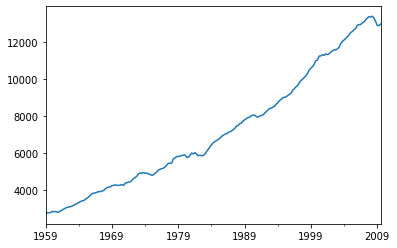

In [9]:
df.realgdp.plot();

### Hodrick-Prescott Filter
Separates ***time series*** data $y_{t}$ into ***trend*** ("stochastic") ${\tau}_{t}$ and ***cyclical*** ("non-stochastic") ${\zeta}_{t}$ components

$y_{t}$ = ${\tau}_{t}$ + ${\zeta}_{t}$

Components ("weights") are "optimized" by minimizing loss function:
$\min_{\\{ \tau_{t}\\} }\sum_{t}^{T}\zeta_{t}^{2}+\lambda\sum_{t=1}^{T}\left[\left(\tau_{t}-\tau_{t-1}\right)-\left(\tau_{t-1}-\tau_{t-2}\right)\right]^{2}$

^*"intuitive"* sense: 
* left term is to minimize noise/cyclical term
* right term is to penalize overfitting to trend term

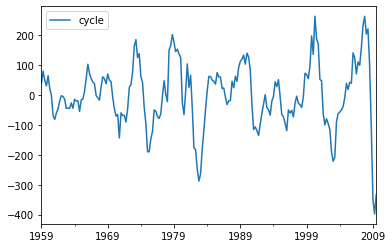

In [21]:
gdp_cycle, gdp_trend = sm.tsa.filters.hpfilter(df['realgdp'])
# df['realgdp'].tail(50).plot(label='realgdp');
# gdp_trend.tail(50).plot(label='trend');
gdp_cycle.plot(label='cycle');
plt.legend();

### EWMA (Exponential Weighted Moving Average)


#### In general:

$ y_{t} = \frac{\sum\limits_{i=0}^{t} w_{i}x_{t-i} }{\sum\limits_{i=0}^{t} w_i} $

#### 3 Ways of Calculating $w_{i}$ (and hence $y_{t}$) using EWMA:
1. If Adjust = False:
    analogous to "*new_pred = coeff * curr_price + (1 - coeff) * prev_pred*"
    
    $ y_{t} = (1 - \alpha) y_{t-1} + \alpha x_{t} $, where $ w_{t} = \begin{cases} \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i & \text{if } i = t \end{cases}$


2. If Adjust = True:

    $ y_{t} = \frac{x_{t} + (1 - \alpha) x_{t-1} + ... + (1 - \alpha)^{t} x_{0}}{1 + (1 - \alpha) + ... + (1 - \alpha)^{t}} $, where $ w_{i} = (1 - \alpha)^{t-i} $
    
#### To calculate $\alpha$:
1. Configure $\alpha$ value directly
2. Use concept of either *span*, *centre of mass* or *half-life*

    $ \alpha = 
        \begin{cases} 
            \frac{2}{s+1} & \text{for span, } s \geq 1 \\
            \frac{1}{1+c} & \text{for centre of mass, } c \geq 0 \\
            1 - exp^{\frac{\log 0.5}{h}} & \text{for half-life, } h \gt 0
    \end{cases} $
    
    *Intuitively*:
    
    * span = last $s$ days to average; the higher $s$ is, the smaller $\alpha$ (and hence relevance of last time-series value) becomes
    
    * centre of mass = mid-pt of last $s$ days to average, since $c=\frac{s-1}{2}$
    
    * half-life = time to decay previous predictions, higher $h$ = lower $\alpha$ (higher relevance of previous predictions, lower relevance of last time-series value)


In [23]:
airline = pd.read_csv('data/airline_passengers.csv', index_col="Month")
airline.dropna(inplace=True)
airline.index = pd.to_datetime(airline.index)
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


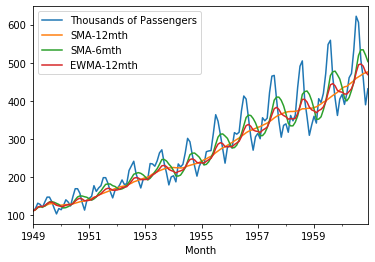

In [31]:
airline['SMA-6mth'] = airline['Thousands of Passengers'].rolling(window=6, min_periods=0).mean()
airline['SMA-12mth'] = airline['Thousands of Passengers'].rolling(window=12, min_periods=0).mean()
airline['EWMA-12mth'] = airline['Thousands of Passengers'].ewm(span=12, min_periods=0).mean()
airline.plot();

### ETS Decomposition
Decomposing time-series into components for prediction/modelling:
1. Error ($E$)
2. Trend ($T$)
3. Seasonality ($S$)

Month
1949-01-01    118.588481
1949-02-01    119.734169
1949-03-01    120.879856
1949-04-01    122.025544
1949-05-01    123.171232
Name: Thousands of Passengers, dtype: float64
Month
1949-01-01    0.911256
1949-02-01    0.890342
1949-03-01    1.012397
1949-04-01    0.980719
1949-05-01    0.979495
Name: Thousands of Passengers, dtype: float64
Month
1949-01-01    1.036418
1949-02-01    1.106896
1949-03-01    1.078621
1949-04-01    1.077940
1949-05-01    1.002938
Name: Thousands of Passengers, dtype: float64


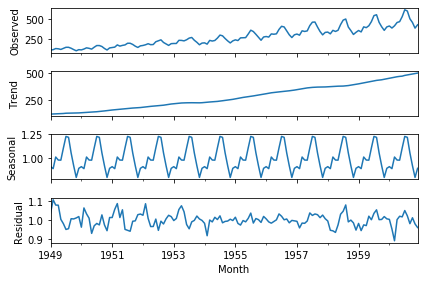

In [44]:
airline_ets = seasonal_decompose(airline['Thousands of Passengers'], model='multiplicative', extrapolate_trend='freq')
print(airline_ets.trend.head())
print(airline_ets.seasonal.head())
print(airline_ets.resid.head())
airline_ets.plot();

### ARIMA (AutoRegressive Integrated Moving Average) Model
* Generalization of AutoRegressive Moving Average (ARMA)
* 2 Types: 1) Non-Seasonal 2) Seasonal

#### Components of ARIMA
1. $p$ : AutoRegression ($AR$) - regression model associating current and previous periods' values
2. $d$ : Integrated ($I$) - differencing of observations (taking difference between previous and current values) in order to make time series stationary
3. $q$ : Moving Average ($MA$) - residual error between values & moving averages applied to lagged (historical) values

#### Concept of *Stationarity*
* Constant mean/var/covar over time - to predict same mean/var/covar for future periods
* Degree of Stationarity tested via Augmented Dickey-Fuller test
* If dataset is not stationary, need to transform via differencing $d$ above
    * akin to doing secondary school quadratic generalization -> take difference in series till the difference values become constant; can also take difference across $x$ (!= 1) shifted periods